In [12]:
import librosa, librosa.display, librosa.util
import matplotlib.pyplot as plt
import numpy as np

In [13]:
y, sr = librosa.load('./audio/StarS.wav')
C = np.abs(librosa.cqt(y, sr=sr, hop_length=64, n_bins=84, bins_per_octave=12))

> C - 分音矩阵  
> C.shape - 84个音， 时间帧

In [14]:
type(C)
print(C.shape)

(84, 2765)


# Dimensionality Deduction  
Output: d_C as dimension-deducted C matrix  

Take every 5 frames to 1 using average  
**Time as y_axis, changed from here**  

Calculated after C

In [37]:
d_C = np.zeros([1, C.shape[0]])
local_sum = np.zeros([1, C.shape[0]])
# 84*1


i=0
de_di_rate = 32
for i in range(0, C.shape[1]):
    if (i+1)%de_di_rate != 0:
        local_sum += C[:,i]
    else:
        local_sum /= de_di_rate
        d_C = np.r_[d_C, local_sum]
        local_sum = np.zeros([1, C.shape[0]])
        
if (i+1)%de_di_rate != 0:
    local_sum /= (i+1)%de_di_rate
    d_C = np.r_[d_C, local_sum]

> 检查时间帧顺序，d_C中第一帧的[0]此时可用作参考  

In [36]:
print(d_C)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.89153405e-03 2.18231400e-03 2.93586570e-03 ... 1.61692366e-05
  1.77254463e-05 1.81078254e-05]
 [2.14011595e-02 8.54435577e-03 1.66741141e-02 ... 6.67155131e-05
  6.18385536e-05 7.03909707e-05]
 ...
 [2.55296035e-02 7.88990752e-02 7.52494025e-02 ... 1.23546209e-04
  1.12717019e-04 1.04306168e-04]
 [3.55073796e-02 7.76866996e-02 6.65336209e-02 ... 1.92732741e-04
  1.66047016e-04 1.52957966e-04]
 [1.86698573e-02 4.91173002e-02 7.15783940e-02 ... 1.89593075e-04
  1.41269191e-04 1.27747995e-04]]


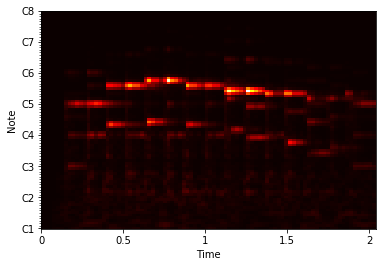

In [38]:
librosa.display.specshow(np.transpose(d_C), sr=sr, x_axis='time', y_axis='cqt_note')
plt.set_cmap('hot')
plt.show()

# Denoising  
Output: n_C as normalized C matrix
- Normalization  
- Threshold  

Calculated after d_C

In [39]:
n_C = d_C/np.max(d_C)
SIGMA = 0.1
for i in range(0, n_C.shape[0]):
    for j in range(0, n_C.shape[1]):
        if n_C[i][j] < SIGMA:
            n_C[i][j] = 0
            

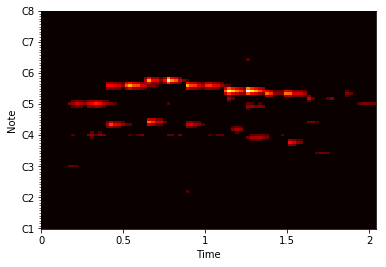

In [40]:
librosa.display.specshow(np.transpose(n_C), sr=sr, x_axis='time', y_axis='cqt_note')
plt.set_cmap('hot')
plt.show()

# Euclidean Distance  

${\Sigma_i{{(x[i]-y[i])}}^2}$  

In [43]:
print(type(n_C), n_C.shape)

<class 'numpy.ndarray'> (88, 84)


In [54]:
eu_dst = np.zeros([n_C.shape[0] - 1, n_C.shape[1]])
for i in range(0, n_C.shape[0] - 1):
    eu_dst[i] = (n_C[i] - n_C[i+1]) * (n_C[i] - n_C[i+1])

In [ ]:
data = eu_dst.reshape(1, eu_dst.shape[0] * eu_dst.shape[1])
plt.hist(data)
plt.show()